In [7]:
import data_grid
import numpy as np

from xrdc import xrdutils as xdu
from xrdc import geometry as geo
from xrdc import simulation as sim
from xrdc import visualization as vis
from xrdc import metrics
from xrdc import grid_data as gd

from siamese_xrd import train, utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ternary

from bayes_opt import UtilityFunction
from bayes_opt import BayesianOptimization

Loading Data from: ../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/
Data Loaded Succesfully
(177, 800)


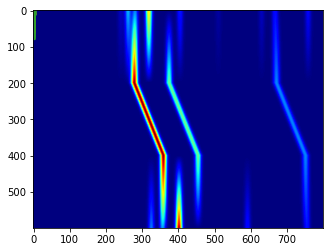

In [8]:
# TODO move to module

path = "../../TiNiSn_500C-20190604T152446Z-001/TiNiSn_500C/"

dgrid = data_grid.DataGrid(path, """TiNiSn_500C_Y20190218_14x14_t60_(?P<num>.*?)_bkgdSub_1D.csv""",range=None)

X=dgrid.get_data_array()
q=dgrid.data[1][:,0]

N = X.shape[0]

coords = np.array([np.array(dgrid.coord(ii+1)) for ii in range(N)])

CoNi = pd.read_json("../xrdc/inputs/mp-1226076_xrd_Cu_CoNi.json", lines=True)
Co = pd.read_json("../xrdc/inputs/mp-1183710_xrd_Cu_Co.json", lines=True)
Ni = pd.read_json("../xrdc/inputs/mp-10257_xrd_Cu_Ni.json", lines=True)
Sn = pd.read_json("../xrdc/inputs/mp-117_xrd_Cu_Sn.json", lines = True)

_, _, ib, qb = xdu.plt_pat(CoNi);
qqa, iia, ia, qa = xdu.plt_pat(Co);
qqc, iic, ic, qc = xdu.plt_pat(Ni);

sigma = .03
N = 200
shift_size = .2

Co_to_CoNi_shift = sim.transition(-shift_size, -shift_size, (qa, ia), (qb, ib), N, sigma, scale_type = 'shift')

CoNi_to_CoNi_shift = sim.transition(-shift_size, shift_size, (qb, ib), (qb, ib), N, sigma, scale_type = 'shift')

CoNi_to_Ni_shift = sim.transition(shift_size, shift_size, (qb, ib), (qc, ic), N, sigma, scale_type = 'shift')

X = np.vstack((Co_to_CoNi_shift, CoNi_to_CoNi_shift, CoNi_to_Ni_shift))
plt.imshow(X, cmap = 'jet')

In [11]:
waferx, wafery = coords.T
R = np.sqrt((waferx - waferx.mean())**2 + (wafery - wafery.mean())**2).max() + .1

xx, yy = (waferx - waferx.mean()) / R, (wafery - wafery.mean()) / R
sx, sy = geo.circle_to_simplex(waferx, wafery)
xx, yy, zz = ternary.helpers.planar_to_coordinates(np.vstack((sx, sy)), 1)

def composition_to_patterns(*compositions, single_phase_threshold = .5):
    xx, yy, zz = compositions #compositions[:, 0], compositions[:, 1], compositions[:, 2]

    peakshift_val = (-xx + zz)
    # index into the array of 200 different-peak shift patterns
    peakshift_idx = ((N * peakshift_val).astype(int) + (N)) // 2

    s1_pat = Co_to_CoNi_shift[0]
    s3_pat = CoNi_to_Ni_shift[-1]

    single_phase_mask = (zz > single_phase_threshold)
    s1_weighted = (xx[:, None] * s1_pat) * (~single_phase_mask)[:, None]
    #s2_weighted = yy[:, None] * CoNi_to_CoNi_shift[peakshift_idx]
    s2_weighted = (single_phase_mask)[:, None] * CoNi_to_CoNi_shift[peakshift_idx]\
            + (yy[:, None] * CoNi_to_CoNi_shift[peakshift_idx]) * (~single_phase_mask)[:, None]
    s3_weighted = (zz[:, None] * s3_pat) * (~single_phase_mask)[:, None]



    total = s1_weighted + s2_weighted + s3_weighted
    assert np.isclose(total.mean(axis = 1), 1).all()
    return s1_weighted, s2_weighted, s3_weighted, total

s1_weighted, s2_weighted, s3_weighted, total = composition_to_patterns(xx, yy, zz)

this should be balanced: 55 55 67


In [3]:
def gen_data(dataGrid, scale_type, scale_min = -.25, scale_max = .25, N_augment = 20, N_neighbor = 6, augment = True, **plot_args):
    """
    Group XRD patterns from a wafer library by neighborhood
    """
    X=dataGrid.get_data_array()
    q=dataGrid.data[1][:,0]

    N = X.shape[0]

    coords = np.array([np.array(dgrid.coord(ii+1)) for ii in range(N)])

    Y = gd.group_by_coord(coords, N_neighbor)

    plt.scatter(*(coords.T), c = Y, **plot_args)
    if augment:
        X, Y = xdu.augment(X, Y, scale_min, scale_max, q, N = N_augment, scale_type = scale_type)
    X, Y = xdu.standardize_input(X, Y)
    return X, Y

|   iter    |  target   | n_neig... |
-------------------------------------
(177, 800)


NameError: name 'XX' is not defined

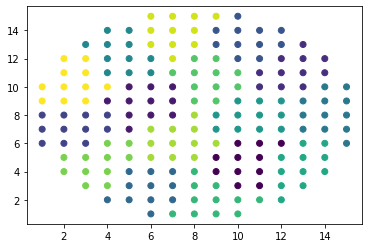

In [12]:
num_random_points = 1
num_iter = 0

neighbor_range = (3, 12.001)
#augment_range = (5, 20)
#scale_range = (0, .5)

def run_and_eval_real_instance(n_neighbor, n_augment = 20, scale_size = .5, base_prefix = 'inst12_Cu3Bi4V6', epochs = 200):
#     X, Y = I, grid_data.group_by_coord(cpairs, n_neighbor = int(n_neighbor))

#     XX, YY = xdu.augment(X, Y, 1 - scale_size / 2, 1 + scale_size / 2, q, N = int(n_augment), scale_type = 'scale')

#     XX, YY = xdu.standardize_input(XX, YY)

#     X, Y = xdu.standardize_input(X, Y)
    X, Y = gen_data(dgrid, 'shift', -scale_size / 2, scale_size / 2, N_neighbor = int(n_neighbor))
    
    #{}_scale_size_{}_n_augment_{}
    prefix = "${}_{:.0f}_n_neighbor_".format(base_prefix, n_neighbor)
    xdu.write_train_test("data/{}/".format(prefix), XX, YY,
                     X,\
                     Y)
    
    net, train_loader, test_loader, original_train_loader, original_test_loader, add_prefix, stats_collector =\
        train.run("siamese-constrastive_1d", "XRD", "data/{}/train/".format(prefix), "data/{}/test".format(prefix), name = prefix,
              n_classes = Y.max() + 1, epochs = epochs)
    
    score = metrics.approx_mean_density(X, Y, net, utils.get_embedding, .2)
    print(score)
    return score


optimizer = BayesianOptimization(f=run_and_eval_real_instance,
            pbounds={'n_neighbor': neighbor_range,
                     #'n_augment':augment_range,  # *16
                     #'scale_size':scale_range
                    },
                     verbose=2)
 
optimizer.maximize(init_points=num_random_points, n_iter=num_iter)
print('nbest result:', optimizer.max)